In [2]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
register_matplotlib_converters()
plt.style.use('ggplot')

# 2020 Coronavirus Australia

Data taken from https://en.wikipedia.org/wiki/2020_coronavirus_outbreak_in_Australia

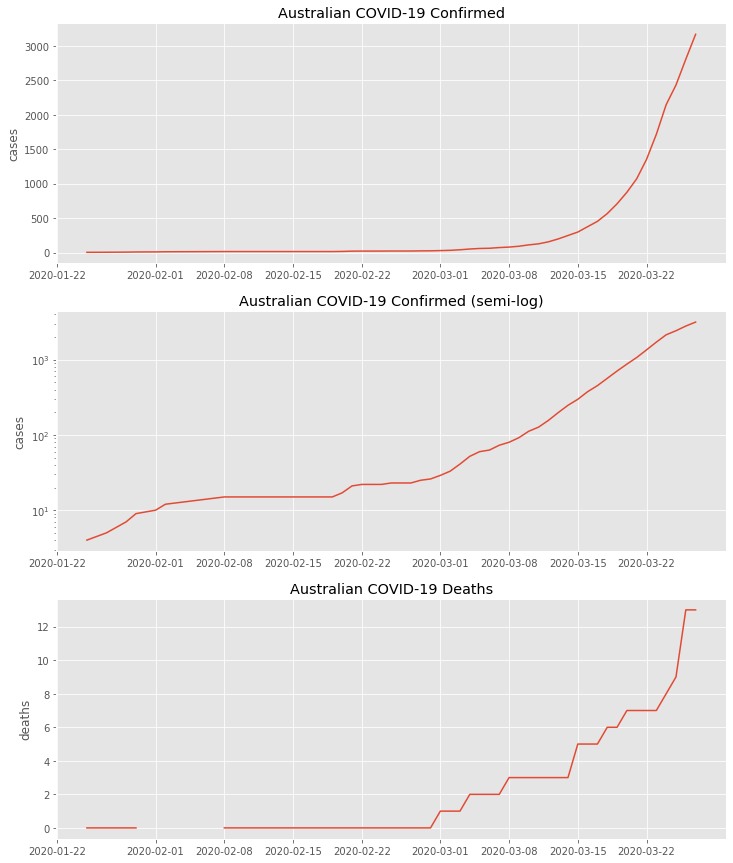

In [203]:
df = pd.read_csv('au_total.csv')
#df = df.iloc[:-1]
df.index = pd.DatetimeIndex(df.date.values, dayfirst=True)
df.drop('date', inplace=True, axis=1)

# calculate % change (growth)
df['growth'] = df['confirmed'].pct_change() * 100


fig = plt.figure(figsize=(12, 15))

# Confirmed Cases
ax1 = fig.add_subplot(311)
ax1.plot(df.confirmed)
ax1.set_title('Australian COVID-19 Confirmed')
ax1.set_ylabel('cases')

# Confirmed (semi-log)
ax2 = fig.add_subplot(312)
ax2.plot(df.confirmed)
ax2.set_yscale('log')
ax2.set_ylabel('cases');
ax2.set_title('Australian COVID-19 Confirmed (semi-log)');

# Deaths
ax3 = fig.add_subplot(313)
ax3.plot(df.deaths)
ax3.set_ylabel('deaths');
ax3.set_title('Australian COVID-19 Deaths');

# Exponential Curve Fit

a: 0.3655009860642045 b: 0.1825514616970745 c: 6.050620053070694e-11


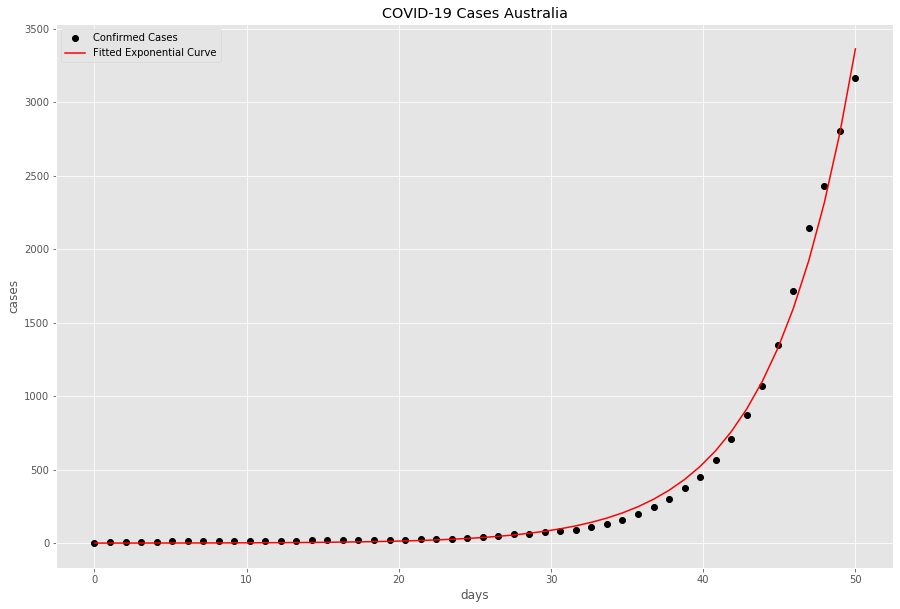

In [188]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(b * x) + c


x = np.linspace(0, df.shape[0], df.shape[0])
confirmed = df.confirmed.values
popt, pcov = curve_fit(func, x, confirmed, bounds=(0, [20., 1., 10.]))

print('a: {0} b: {1} c: {2}'.format(popt[0], popt[1], popt[2]))

fig = plt.figure(figsize=(15, 10))
plt.plot(x, confirmed, 'ko', label="Confirmed Cases")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Exponential Curve")
plt.title('COVID-19 Cases Australia')
plt.xlabel('days');
plt.ylabel('cases');
plt.legend();

# Future predictions

In [189]:
current_days = df.shape[0]
# find scale factor to match exactly 
# current days to max confirmed cases
scale_factor = 0
for i in range(0, 1000):
    scale_factor = scale_factor + 0.001
    result = func(current_days - scale_factor, *popt)
    if (result - df.confirmed.max()) < 0:
        break

day = 1 - scale_factor
print(day)
print('Current total: {0:,}'.format(df.confirmed.max()))
print('Predicted next day: {0:,}'.format(int(func(current_days + day, *popt))))
print('Predicted next three days: {0:,}'.format(int(func(current_days + 3 * day, *popt))))
print('Predicted next week (7 days): {0:,}'.format(int(func(current_days + 7 * day, *popt))))
print('Predicted in two weeks (14 days): {0:,}'.format(int(func(current_days + 14 * day, *popt))))

0.6679999999999997
Current total: 3,167
Predicted next day: 3,801
Predicted next three days: 4,850
Predicted next week (7 days): 7,900
Predicted in two weeks (14 days): 18,551


# Statsmodel Exponential Fit

In [191]:
import statsmodels.api as sm

df['log_confirmed'] = np.log(df.confirmed)

X = np.arange(0, df.shape[0])
X = sm.add_constant(X)
y = df.log_confirmed.values

model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     666.0
Date:                Fri, 27 Mar 2020   Prob (F-statistic):           8.61e-30
Time:                        18:08:41   Log-Likelihood:                -34.126
No. Observations:                  50   AIC:                             72.25
Df Residuals:                      48   BIC:                             76.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2481      0.136      9.166      0.0

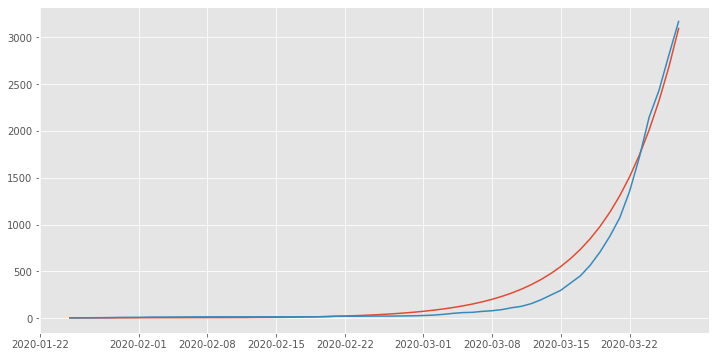

In [193]:
x0 = np.exp(1.0)
b = np.exp(0.1436)

result = x0 * np.power(b, np.arange(0, 50))

df['pred'] = result

fig = plt.figure(figsize=(12, 6))
plt.plot(df.pred)
plt.plot(df.confirmed)